# Python: Group Average Treatment Effects (GATEs) for PLR models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate group average treatment effects in the [DoubleMLPLR](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) model.

## Data

Consider the following partially linear model

$$
\begin{align*}
Y &= \theta(X) D + g(X) + \varepsilon\\
D &= m(X) + \nu
\end{align*}
$$

with 

$$
\begin{align*}
\mathbb{E}[\varepsilon|D, X] &= 0\\
\mathbb{E}[\nu|X] &= 0.
\end{align*}
$$

The data will be generated with a simple data generating process to enable us to know the true group effects.

Here, we consider three different groups which depend on the first covariate, which could correspond to e.g. three different age groups in the sample.
For simplicity, the treatment effect within each group is generated to be constant, such that the data generating process corresponds to the model.

If the effect within each group would be heterogeneous, the model would estimate the average treatment effect within each group.

In [1]:
def group_effect(x):
    if x[0] <= -0.7:
        te = 3
    elif (x[0] > -0.7) & (x[0] <= 0.2):
        te = 1
    else:
        te = 0
    return te

Here the group effect are solely defined based on the first feature: 

$$
\theta(X):=
\begin{cases} 
3, \text{ if } X_1 \le -0.7\\
1, \text{ if } -0.7 <X_1 \le 0.2\\
0, \text{ if } 0.2 < X_1
\end{cases}
$$

In [2]:
import numpy as np
import pandas as pd
import doubleml as dml

In [3]:
def dgp(n, p, support_size):
    X = np.random.uniform(-1, 1, size=(n,p))

    support = np.random.choice(np.arange(p), size=support_size, replace=False)
    coefs_D = np.random.uniform(0, 1, size=support_size)
    coefs_Y = np.random.uniform(0, 1, size=support_size)

    # Define the function to generate the noise
    epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n)

    D = np.dot(X[:, support], coefs_D) + epsilon_sample(n)
    theta_x = np.apply_along_axis(group_effect, axis=1, arr=X)
    Y = theta_x * D + np.dot(X[:, support], coefs_Y) + epsilon_sample(n)
    df = pd.DataFrame(X, columns=[f'X_{i}' for i in range(p)])
    df['D'] = D
    df['Y'] = Y
    return df

In [4]:
n = 500
p = 5
support_size = 5

df = dgp(n, p, support_size)
dml_data = dml.DoubleMLData(df, y_col='Y', d_cols='D')
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['D']
Covariates: ['X_0', 'X_1', 'X_2', 'X_3', 'X_4']
Instrument variable(s): None
No. Observations: 500

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 7 entries, X_0 to Y
dtypes: float64(7)
memory usage: 27.5 KB



## Partially Linear Regression Model (PLR)
The first step is to fit a [DoubleML PLR Model](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) to the data.
This will estimate the average treatment effect.

In [5]:
# First stage estimation
from sklearn.ensemble import RandomForestRegressor
rf_ml_l = RandomForestRegressor(n_estimators=500)
rf_ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(dml_data,
                          ml_l=rf_ml_l,
                          ml_m=rf_ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model
       coef   std err          t         P>|t|     2.5 %    97.5 %
D  0.925308  0.080305  11.522422  1.017117e-30  0.767913  1.082703


## Group Average Treatment Effects (GATEs)
Next, we can specify the groups as [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with boolean columns.

In [7]:
groups = pd.DataFrame(
    np.column_stack([df['X_0'] <= -0.7,
                     (df['X_0'] > -0.7) & (df['X_0'] <= 0.2),
                     df['X_0'] > 0.2]),
    columns=['Group 1', 'Group 2', 'Group 3'])
print(groups.head())

   Group 1  Group 2  Group 3
0    False     True    False
1    False     True    False
2    False     True    False
3    False     True    False
4     True    False    False


To calculate GATEs just call the ``gate()`` method and supply the DataFrame with the group definitions and the ``level`` (with default of ``0.95``).

In [8]:
gate = dml_plr.gate(groups=groups)
print(gate.confint(level=0.95))

            2.5 %    effect    97.5 %
Group 1  2.598868  2.970404  3.341940
Group 2  0.829584  0.967269  1.104954
Group 3 -0.075318  0.069070  0.213458


The confidence intervals above are point-wise, but by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [9]:
ci = gate.confint(level=0.95, joint=True, n_rep_boot=1000)
print(ci)

            2.5 %    effect    97.5 %
Group 1  2.268323  2.970404  3.672485
Group 2  0.707089  0.967269  1.227448
Group 3 -0.203776  0.069070  0.341916


Finally, let us plot the estimates together with the true effect within each group.

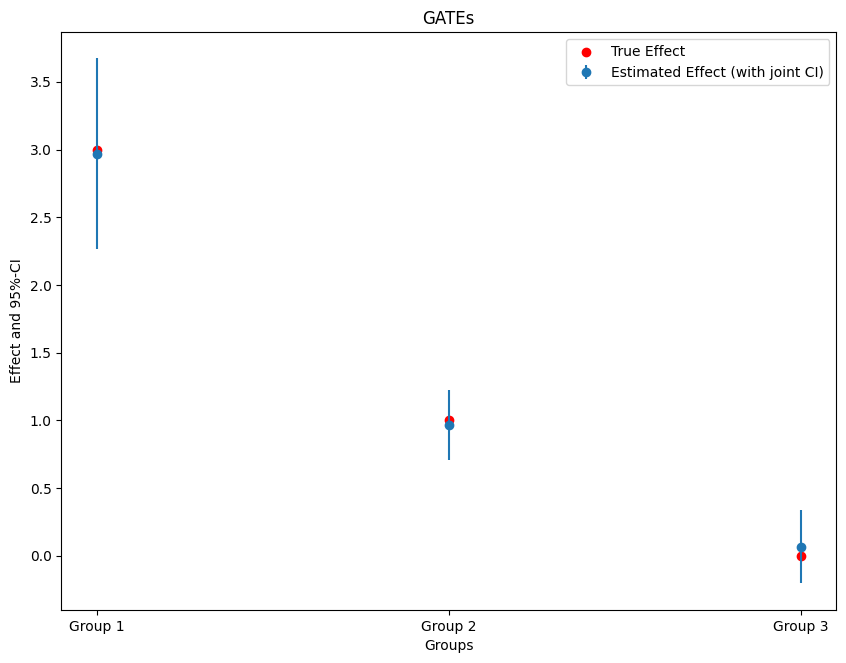

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors, label='Estimated Effect (with joint CI)')

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group 1', 'Group 2', 'Group 3'], y=[3, 1, 0], c='red', label='True Effect')

plt.title('GATEs')
plt.xlabel('Groups')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')

It is also possible to supply disjoint groups as a single vector (still as a data frame). Remark the slightly different name.

In [11]:
groups =  pd.DataFrame(columns=['Group'], index=range(df['X_0'].shape[0]), dtype=str)
for i, x_i in enumerate(df['X_0']):
    if x_i <= -0.7:
         groups['Group'][i] = '1'
    elif (x_i > -0.7) & (x_i <= 0.2):
         groups['Group'][i] = '2'
    else:
         groups['Group'][i] = '3'

print(groups.head())

  Group
0     2
1     2
2     2
3     2
4     1


In [13]:
gate = dml_plr.gate(groups=groups)
ci = gate.confint()
print(ci)

            2.5 %    effect    97.5 %
Group_1  2.598868  2.970404  3.341940
Group_2  0.829584  0.967269  1.104954
Group_3 -0.075318  0.069070  0.213458


The coefficients of the best linear predictor can be seen via the summary (the values can be accessed through the underlying model ``.blp_model``).

In [14]:
print(gate.summary)

             coef   std err          t         P>|t|    [0.025    0.975]
Group_1  2.970404  0.140982  21.069408  6.798647e-71  2.693410  3.247398
Group_2  0.967269  0.081744  11.832961  1.236484e-28  0.806663  1.127875
Group_3  0.069070  0.088560   0.779920  4.358090e-01 -0.104929  0.243069


Remark that the confidence intervals are slightly smaller, since they are not based on the White's heteroskedasticity robus standard errors.

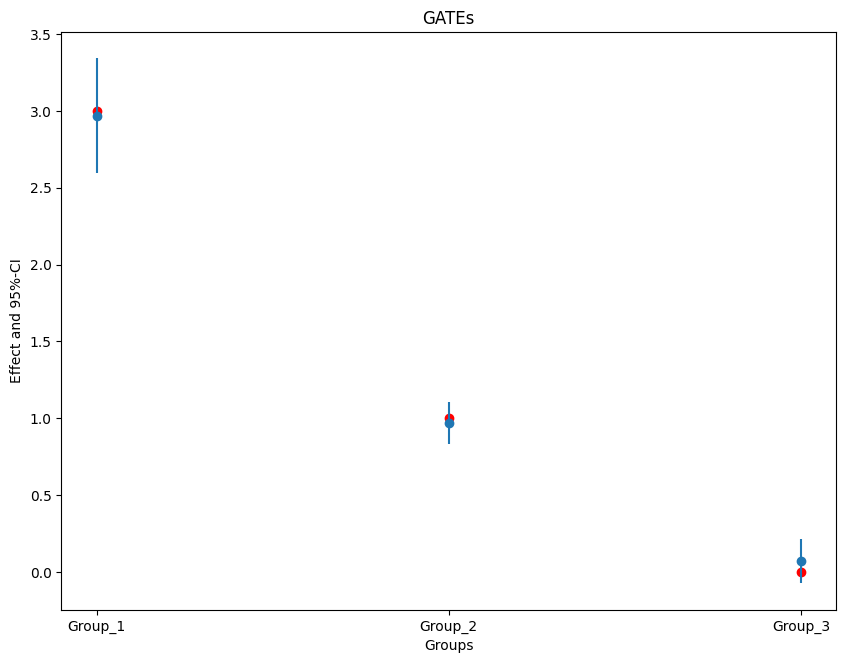

In [15]:
errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group_1', 'Group_2', 'Group_3'], y=[3, 1, 0], c='red', label='True Effect')

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors)
plt.title('GATEs')
plt.xlabel('Groups')
_ =  plt.ylabel('Effect and 95%-CI')